<IPython.core.display.Javascript object>


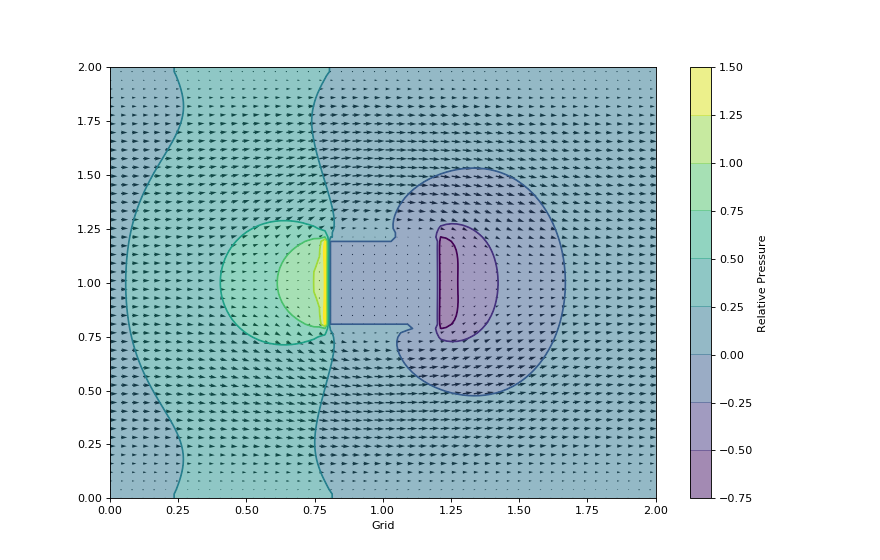

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation    

num = 10

class fluid_model(object):
    def __init__(self, x0=0, x1=2, y0=0, y1=2, N=100, t_max=10.0, vel=1.0, rho=1.0, nu=0.1, Force=1.0):
        self.N = N            # outer most ghost layer of grid for BC's 
        self.t_max = t_max
        self.vel = vel
        self.rho = rho
        self.nu = nu
        self.Force = Force
        
        self.Nx = self.N              # make changes here if square grid is not the case
        self.Ny = self.N
        
        self.delta_x = abs(x1-x0)/self.Nx          ### for functionality only  otherwise both will be same
        self.delta_y = abs(y1-y0)/self.Ny
        
        self.gridx = np.linspace(x0,x1,self.Nx)      ### can be ax,bx and ay,by
        self.gridy = np.linspace(y0,y1,self.Ny)
        
        self.u = np.zeros((self.Nx,self.Nx))     ## 2D (N*N) grid
        self.v = np.zeros((self.Ny,self.Ny))
        
        self.p = np.zeros((self.N,self.N))
        self.half = np.zeros((self.N,self.N))
################################################################################################################
        
a = fluid_model()



        
        
def update_p():
    dt = 0.0005       #### might need to change as per grid and velocity parameters
    dx = a.delta_x
    dy = a.delta_y
    un = a.u.copy()
    vn = a.v.copy()
    p_n = a.p.copy()
    rho = a.rho
    n = a.N
    
    #### half the equation ####
    k = a.half.copy()
    k[1:-1,1:-1] = (1/dt) * ( (un[1:-1,2:] - un[1:-1,:-2])/(2*dx) + (vn[2:,1:-1] - vn[:-2,1:-1])/(2*dy)) \
                    - ((un[1:-1,2:] - un[1:-1,:-2])/(2*dx))**2 - ((vn[2:,1:-1] - vn[:-2,1:-1])/(2*dy))**2 \
                    - 2 * ((un[2:,1:-1] - un[:-2,1:-1])/(2*dy)) * ((vn[1:-1,2:] - vn[1:-1,:-2])/(2*dx))
    ########################################################################################################
    ####### BC at x=2  ###############################################################################
    
    k[1:-1,-1] = (1/dt) * ( (un[1:-1,0] - un[1:-1,-2])/(2*dx) + (vn[2:,-1] - vn[:-2,-1])/(2*dy)) \
                    - ((un[1:-1,0] - un[1:-1,-2])/(2*dx))**2 - ((vn[2:,-1] - vn[:-2,-1])/(2*dy))**2 \
                    - 2 * ((un[2:,-1] - un[:-2,-1])/(2*dy)) * ((vn[1:-1,0] - vn[1:-1,-2])/(2*dx))
    
    ####### BC at x=0  ################################################################################
    
    k[1:-1,0] = (1/dt) * ( (un[1:-1,1] - un[1:-1,-1])/(2*dx) + (vn[2:,0] - vn[:-2,0])/(2*dy)) \
                    - ((un[1:-1,1] - un[1:-1,-1])/(2*dx))**2 - ((vn[2:,0] - vn[:-2,0])/(2*dy))**2 \
                    - 2 * ((un[2:,0] - un[:-2,0])/(2*dy)) * ((vn[1:-1,1] - vn[1:-1,-1])/(2*dx))
    
    ########################################################################################################
    
    
    diff = 1
    step = 0
    while(step<100):        #### iterations for pressure to settle
        p_n = a.p.copy()
        a.p[1:-1,1:-1] = ( (p_n[1:-1,2:] + p_n[1:-1,:-2]) * dy**2 + (p_n[2:,1:-1] + p_n[:-2,1:-1]) * dx**2 \
                          - (rho * dx**2 * dy**2 * k[1:-1,1:-1]) ) / (2 * (dx**2+dy**2))
    ########################################################################################################
    ########## Bc #########    
        a.p[1:-1,-1] = ( (p_n[1:-1,0] + p_n[1:-1,-2]) * dy**2 + (p_n[2:,-1] + p_n[:-2,-1]) * dx**2 \
                          - (rho * dx**2 * dy**2 * k[1:-1,-1]) ) / (2 * (dx**2+dy**2))
        
        a.p[1:-1,0] = ( (p_n[1:-1,1] + p_n[1:-1,-1]) * dy**2 + (p_n[2:,0] + p_n[:-2,0]) * dx**2 \
                          - (rho * dx**2 * dy**2 * k[1:-1,0]) ) / (2 * (dx**2+dy**2))
        
    ########################################################################################################
            
        a.p[0,:] = a.p[1,:]     ### dp/dy=0 at y=0
        a.p[-1,:] = a.p[-2,:]           ### dp/dy=0 at y=2
        
        a.p[n//2-num:n//2+num,n//2-num] = a.p[n//2-num:n//2+num,n//2-num-1]
        a.p[n//2-num:n//2+num,n//2+num] = a.p[n//2-num:n//2+num,n//2+num+1]
        a.p[n//2-num,n//2-num:n//2+num] = a.p[n//2-num-1,n//2-num:n//2+num]
        a.p[n//2+num,n//2-num:n//2+num] = a.p[n//2+num+1,n//2-num:n//2+num]
        
        a.p[n//2-num:n//2+num,n//2-num:n//2+num] = 0
        #diff = (np.sum(a.p)-np.sum(p_n)) 
        step += 1
        #if(step==100):break
    #a.p = p_n
    #print(step)

def update_u():
    dt = 0.0005      #### might need to change as per grid and velocity parameters
    dx = a.delta_x
    dy = a.delta_y
    vn = a.v.copy()
    un = a.u.copy()
    p = a.p.copy()
    rho = a.rho
    nu = a.nu
    F = a.Force
    
    a.u[1:-1, 1:-1] = un[1:-1,1:-1]- un[1:-1,1:-1] * dt / dx * (un[1:-1,1:-1] - un[1:-1,:-2]) \
                      - vn[1:-1,1:-1] * dt / dy * (un[1:-1,1:-1] - un[:-2,1:-1]) \
                      - dt / (2 * rho * dx) * (p[1:-1,2:] - p[1:-1,:-2]) + nu * (dt / dx**2 \
                    * (un[1:-1,2:] - 2 * un[1:-1,1:-1] + un[1:-1,:-2]) + dt / dy**2 \
                    * (un[2:,1:-1] - 2 * un[1:-1,1:-1] + un[:-2,1:-1])) + (F * dt)
    
    
    #a.u = un

def update_v():
    dt = 0.0005    #### might need to change as per grid and velocity parameters
    dx = a.delta_x
    dy = a.delta_y
    vn = a.v.copy()
    un = a.u.copy()
    p = a.p.copy()
    rho = a.rho
    nu = a.nu
    
    a.v[1:-1, 1:-1] = (vn[1:-1,1:-1]- un[1:-1,1:-1] * dt / dx * (vn[1:-1,1:-1] - vn[1:-1,:-2]) \
                      - vn[1:-1,1:-1] * dt / dy * (vn[1:-1,1:-1] - vn[:-2,1:-1]) \
                      - dt / (2 * rho * dy) * (p[2:,1:-1] - p[:-2,1:-1]) + nu * (dt / dx**2 \
                    * (vn[1:-1,2:] - 2 * vn[1:-1,1:-1] + vn[1:-1,:-2]) + dt / dy**2 \
                    * (vn[2:,1:-1] - 2 * vn[1:-1,1:-1] + vn[:-2,1:-1])))
    
    #a.v = vn

def channel_flow():
    update_p()
    update_u()
    update_v()
    
    dt = 0.0005
    dx = a.delta_x
    dy = a.delta_y
    un = a.u.copy()
    vn = a.v.copy()
    p = a.p.copy()
    rho = a.rho
    nu = a.nu
    F = a.Force
    n = a.N
    
    ############# enforce BC's ############
    a.u[1:-1,-1] = un[1:-1,-1]- un[1:-1,-1] * dt / dx * (un[1:-1,-1] - un[1:-1,-2]) \
                      - vn[1:-1,-1] * dt / dy * (un[1:-1,-1] - un[:-2,-1]) \
                      - dt / (2 * rho * dx) * (p[1:-1,0] - p[1:-1,-2]) + nu * (dt / dx**2 \
                    * (un[1:-1,0] - 2 * un[1:-1,-1] + un[1:-1,-2]) + dt / dy**2 \
                    * (un[2:,-1] - 2 * un[1:-1,-1] + un[:-2,-1])) + (F * dt)
    
    a.u[1:-1,0] = un[1:-1,0]- un[1:-1,0] * dt / dx * (un[1:-1,0] - un[1:-1,-1]) \
                      - vn[1:-1,0] * dt / dy * (un[1:-1,0] - un[:-2,0]) \
                      - dt / (2 * rho * dx) * (p[1:-1,1] - p[1:-1,-1]) + nu * (dt / dx**2 \
                    * (un[1:-1,1] - 2 * un[1:-1,0] + un[1:-1,-1]) + dt / dy**2 \
                    * (un[2:,0] - 2 * un[1:-1,0] + un[:-2,0])) + (F * dt)
    
    a.v[1:-1,-1] = (vn[1:-1,-1]- un[1:-1,-1] * dt / dx * (vn[1:-1,-1] - vn[1:-1,-2]) \
                      - vn[1:-1,-1] * dt / dy * (vn[1:-1,-1] - vn[:-2,-1]) \
                      - dt / (2 * rho * dy) * (p[2:,-1] - p[:-2,-1]) + nu * (dt / dx**2 \
                    * (vn[1:-1,0] - 2 * vn[1:-1,-1] + vn[1:-1,-2]) + dt / dy**2 \
                    * (vn[2:,-1] - 2 * vn[1:-1,-1] + vn[:-2,-1])))
    
    a.v[1:-1,0] = (vn[1:-1,0]- un[1:-1,0] * dt / dx * (vn[1:-1,0] - vn[1:-1,-1]) \
                      - vn[1:-1,0] * dt / dy * (vn[1:-1,0] - vn[:-2,0]) \
                      - dt / (2 * rho * dy) * (p[2:,0] - p[:-2,0]) + nu * (dt / dx**2 \
                    * (vn[1:-1,1] - 2 * vn[1:-1,0] + vn[1:-1,-1]) + dt / dy**2 \
                    * (vn[2:,0] - 2 * vn[1:-1,0] + vn[:-2,0])))
    
    
    a.u[0,:] = 0
    a.u[-1,:] = 0
    a.v[0,:] = 0
    a.v[-1,:] = 0
    
    a.u[n//2-num:n//2+num,n//2-num:n//2+num] = 0
    a.v[n//2-num:n//2+num,n//2-num:n//2+num] = 0
    
    
def simple_plot():
    for i in range(800):     ##### range*dt = time elapsed
        channel_flow()
    fig = plt.figure(figsize=(11,7), dpi=100)
    X, Y = np.meshgrid(a.gridx,a.gridy)
    #plotting the pressure field as a contour
    d = a.p
    plt.contourf(X, Y, a.p, alpha=0.5, cmap='viridis')  
    c1 = plt.colorbar()
    #plotting the pressure field outlines
    plt.contour(X, Y, a.p, cmap='viridis')  
    #plotting velocity field
    plt.quiver(X[::2, ::2], Y[::2, ::2], a.u[::2, ::2], a.v[::2, ::2])
    plt.xlabel('Grid')
    c1.set_label('Relative Pressure')
    plt.show()
    
    fig1 = plt.figure()
    X, Y = np.meshgrid(a.gridx,a.gridy)
    ax1 = fig1.gca(projection='3d')                      
    ax1.plot_surface(X, Y, a.p[:],cmap='viridis')
    plt.title('Relative Pressure Variation')
    
#%matplotlib notebook    
#simple_plot()


######### animation #######

'''
  
%matplotlib notebook
fig = plt.figure(figsize=(11,7), dpi=100)
X, Y = np.meshgrid(a.gridx,a.gridy)
    
def animate(frames):
    channel_flow()
    fig.clear()
    pt1 = plt.quiver(X[::2, ::2], Y[::2, ::2], a.u[::2, ::2], a.v[::2, ::2])
    if np.count_nonzero(a.p) > 0:
        plt.contourf(X, Y, a.p, alpha=0.5, cmap='viridis')  
        c1 = plt.colorbar()
        plt.xlabel('Grid')
        c1.set_label('Relative Pressure')
        pt2 = plt.contour(X, Y, a.p, cmap='viridis')
    else:
        return pt1
    return pt2
    

anim = animation.FuncAnimation(fig,animate,800,interval=20,repeat=False,blit=False)
anim.save('channel_flow_square.mp4')
'''